In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

### Загрузка данных

In [26]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

### Исследование данных

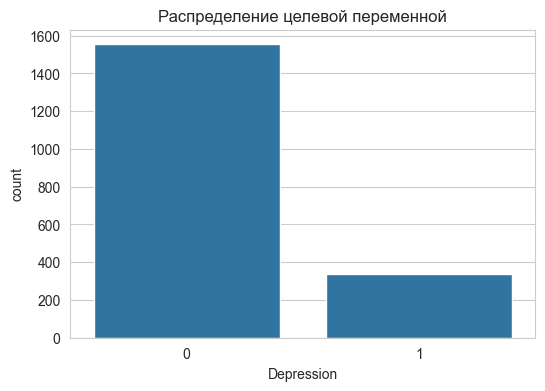

In [27]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Depression', data=train_df)
plt.title('Распределение целевой переменной')
plt.show()

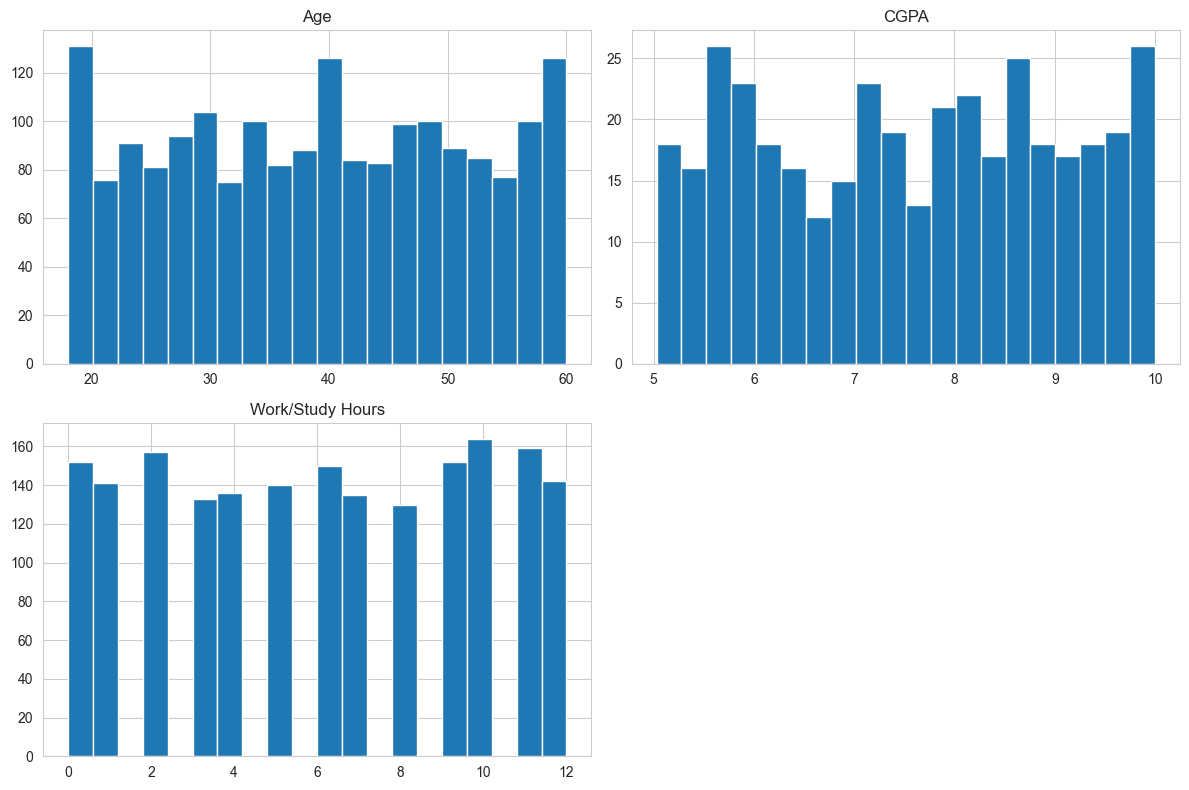

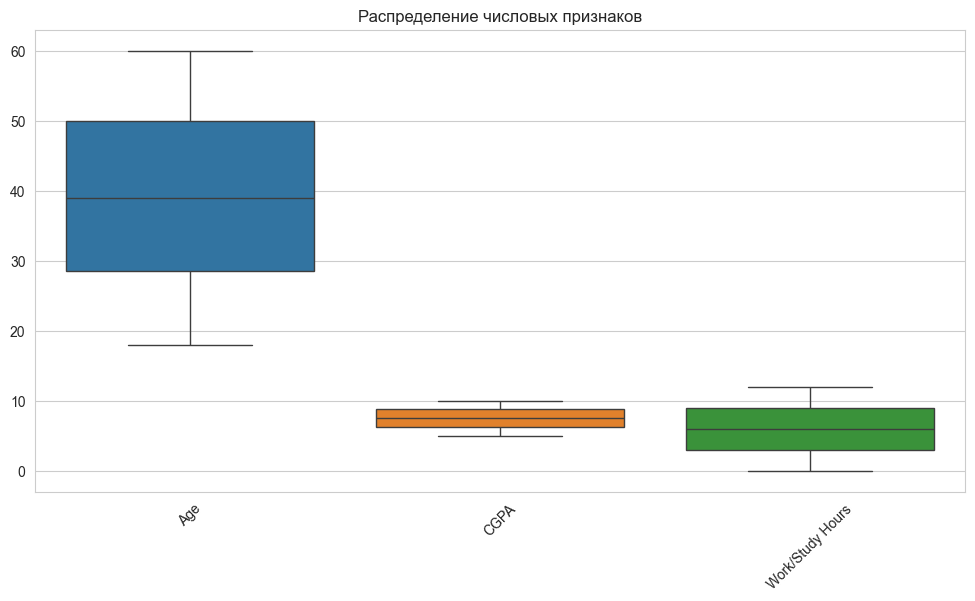

In [28]:
# Гистограммы для числовых признаков
num_cols = ['Age', 'CGPA', 'Sleep Duration', 'Work/Study Hours']
train_df[num_cols].hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Боксплоты для выбросов
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df[num_cols])
plt.title('Распределение числовых признаков')
plt.xticks(rotation=45)
plt.show()

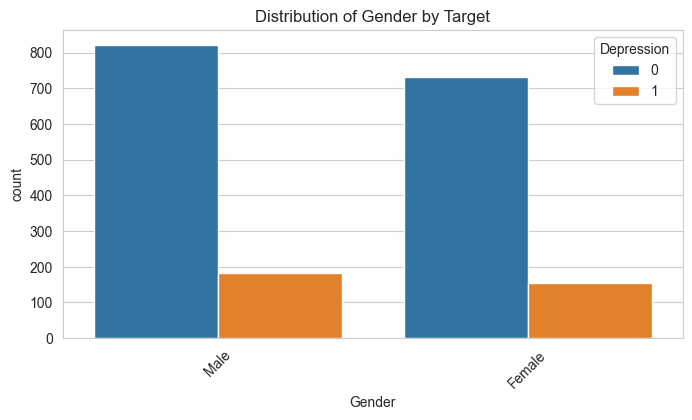

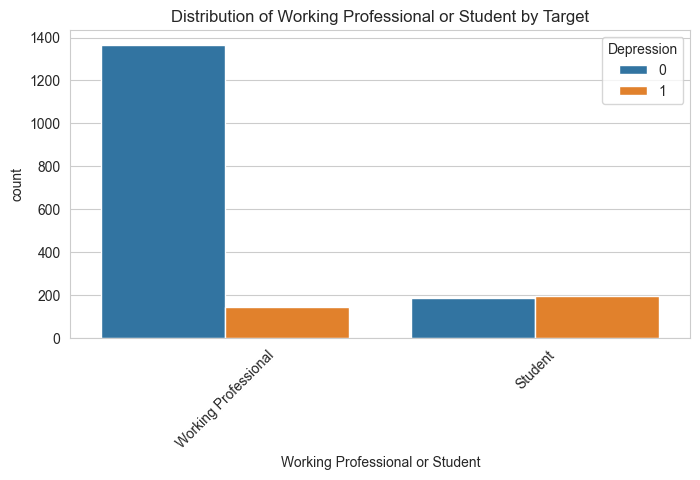

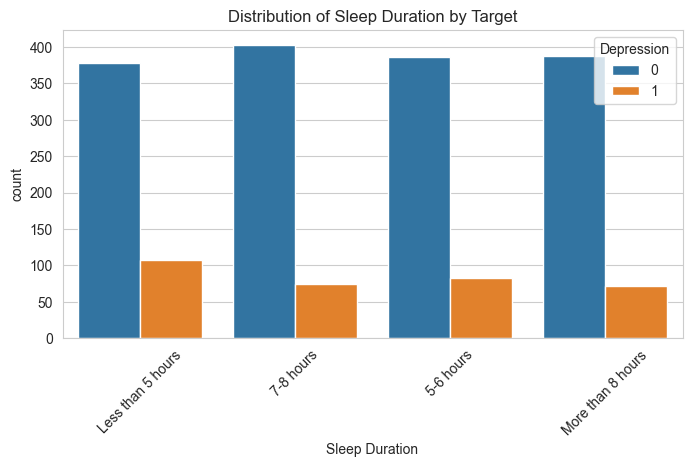

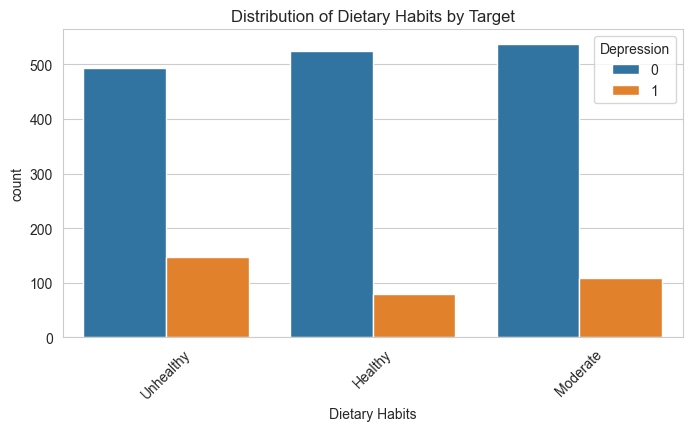

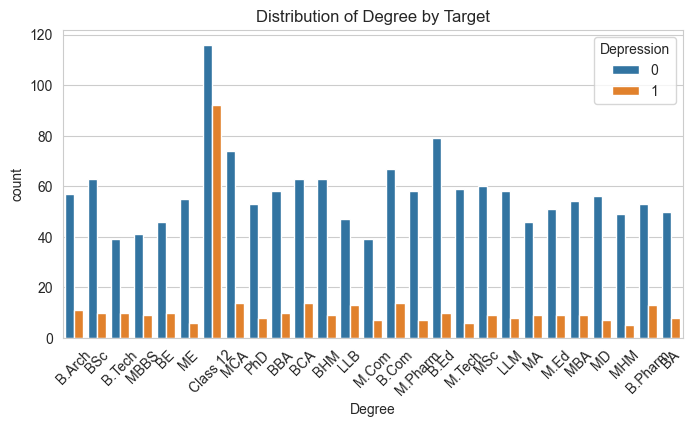

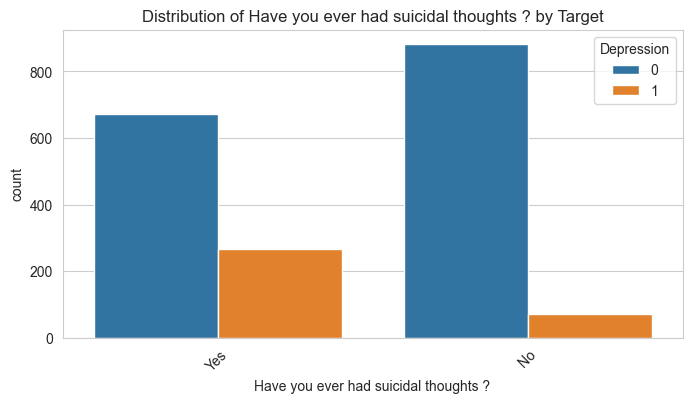

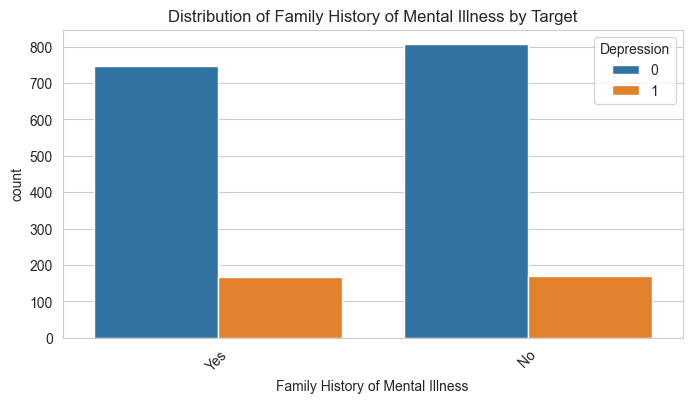

In [29]:
cat_cols = ['Gender', 'Working Professional or Student', 'Sleep Duration', 
            'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 
            'Family History of Mental Illness']
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='Depression', data=train_df)
    plt.title(f'Distribution of {col} by Target')
    plt.xticks(rotation=45)
    plt.show()

### Препроцессинг данных

In [30]:
def preprocess_data(df, is_train=True):
    df = df.copy()

    # Заполняем пропуски в CGPA медианой
    df["CGPA"] = df["CGPA"].fillna(df["CGPA"].median())

    # Объединяем признаки давления и удовлетворенности
    df["Pressure"] = df["Academic Pressure"].fillna(df["Work Pressure"])
    df["Satisfaction"] = df["Study Satisfaction"].fillna(df["Job Satisfaction"])

    # Бинарные признаки
    df["is_student"] = (df["Working Professional or Student"] == "Student").astype(int)
    df["Suicidal"] = (df["Have you ever had suicidal thoughts ?"] == "Yes").astype(int)
    df["FamilyHistory"] = (df["Family History of Mental Illness"] == "Yes").astype(int)

    # Кодирование Sleep Duration
    sleep_map = {
        "Less than 5 hours": 0,
        "5-6 hours": 1,
        "6-7 hours": 2,
        "7-8 hours": 3,
        "More than 8 hours": 4
    }
    df["SleepScore"] = df["Sleep Duration"].map(sleep_map).fillna(-1)

    # Новые признаки
    df["is_young"] = (df["Age"] < 22).astype(int)
    df["overworking"] = (df["Work/Study Hours"] > 10).astype(int)

    # Выбор признаков
    numerical_features = ["Age", "CGPA", "Work/Study Hours", "Financial Stress", "Pressure", "Satisfaction"]
    categorical_features = ["City", "Profession", "Working Professional or Student", "Dietary Habits", "Degree"]
    binary_features = ["is_student", "Suicidal", "FamilyHistory", "SleepScore", "is_young", "overworking"]

    if is_train and "Depression" in df.columns:
        return df[numerical_features + categorical_features + binary_features + ["Depression"]]
    else:
        return df[numerical_features + categorical_features + binary_features]

In [31]:
train_clean = preprocess_data(train_df)
test_clean = preprocess_data(test_df, is_train=False)

X = train_clean.drop("Depression", axis=1)
y = train_clean["Depression"]
X_test = test_clean.copy()

categorical_cols = ["City", "Profession", "Working Professional or Student", "Dietary Habits", "Degree"]
numerical_cols = ["Age", "CGPA", "Work/Study Hours", "Financial Stress", "Pressure", "Satisfaction"]

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

### Пайплайны

In [33]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ("clf", RandomForestClassifier(class_weight="balanced", random_state=42))
])
rf_params = {
    "clf__n_estimators": [100, 200, 300],
    "clf__max_depth": [8, 10, 12, None],
    "clf__min_samples_split": [2, 4],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt", "log2"]
}

logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42))
])
logreg_params = {
    "clf__C": [0.001, 0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["liblinear", "lbfgs"] 
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score)

rf_search = GridSearchCV(rf_pipeline, rf_params, scoring=f1_scorer, cv=cv, n_jobs=-1, verbose=1)
logreg_search = GridSearchCV(logreg_pipeline, logreg_params, scoring=f1_scorer, cv=cv, n_jobs=-1, verbose=1)

### Обучение

In [34]:
print("Обучение Random Forest...")
rf_search.fit(X, y)
print("Лучшие параметры Random Forest:", rf_search.best_params_)
print("Лучший F1 Random Forest:", rf_search.best_score_)

print("\nОбучение Logistic Regression...")
logreg_search.fit(X, y)
print("Лучшие параметры Logistic Regression:", logreg_search.best_params_)
print("Лучший F1 Logistic Regression:", logreg_search.best_score_)

# Подбор порога на валидационной выборке (с использованием лучшей модели)
def optimize_threshold(model, X_val, y_val):
    proba = model.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0.1, 0.9, 80)
    best_thresh = 0.5
    best_f1 = 0
    for thresh in thresholds:
        y_pred = (proba >= thresh).astype(int)
        f1 = f1_score(y_val, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    return best_thresh


X_train_part, X_val, y_train_part, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val_transformed = preprocessor.fit_transform(X_train_part) 
X_val_transformed = preprocessor.transform(X_val)

rf_best_model = rf_search.best_estimator_
rf_proba_val = rf_best_model.predict_proba(X_val)[:, 1]
rf_thresh = optimize_threshold(rf_best_model, X_val, y_val)
print(f"Лучший порог для Random Forest на валидации: {rf_thresh}")

logreg_best_model = logreg_search.best_estimator_
logreg_proba_val = logreg_best_model.predict_proba(X_val)[:, 1]
logreg_thresh = optimize_threshold(logreg_best_model, X_val, y_val)
print(f"Лучший порог для Logistic Regression на валидации: {logreg_thresh}")

rf_proba_test = rf_best_model.predict_proba(X_test)[:, 1]
rf_pred_final = (rf_proba_test >= rf_thresh).astype(int)

logreg_proba_test = logreg_best_model.predict_proba(X_test)[:, 1]
logreg_pred_final = (logreg_proba_test >= logreg_thresh).astype(int)

Обучение Random Forest...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Лучшие параметры Random Forest: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
Лучший F1 Random Forest: 0.8102390950475652

Обучение Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры Logistic Regression: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Лучший F1 Logistic Regression: 0.9258617668539628
Лучший порог для Random Forest на валидации: 0.5455696202531646
Лучший порог для Logistic Regression на валидации: 0.7075949367088608


### Сохранение результатов в файл

In [35]:
output_rf = pd.DataFrame({'id': test_df['id'], 'Depression': rf_pred_final})
output_rf.to_csv('rf_predictions.csv', index=False)
print("Предсказания Random Forest сохранены в rf_predictions.csv")

output_logreg = pd.DataFrame({'id': test_df['id'], 'Depression': logreg_pred_final})
output_logreg.to_csv('logreg_predictions.csv', index=False)
print("Предсказания Logistic Regression сохранены в logreg_predictions.csv")

Предсказания Random Forest сохранены в rf_predictions.csv
Предсказания Logistic Regression сохранены в logreg_predictions.csv


### Какие подходы были до этого и были худшего качества

#### Объединение связанных признаков для линейных моделей
Вероятно усложненный feature engineering сделал результат хуже

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
def preprocess_data(df):
    df = df.copy()

    sleep_map = {
        "Less than 5 hours": 0,
        "5-6 hours": 1,
        "6-7 hours": 2,
        "7-8 hours": 3,
        "More than 8 hours": 4
    }

    # Объединение Pressures и Satisfaction
    df["Pressure"] = df["Academic Pressure"].combine_first(df["Work Pressure"])
    df["Satisfaction"] = df["Study Satisfaction"].combine_first(df["Job Satisfaction"])

    # Заполнение медианой
    for col in ["CGPA", "Pressure", "Satisfaction"]:
        df[col] = df[col].fillna(df[col].median())

    # Пол
    df["is_male"] = (df["Gender"] == "Male").astype(int)

    # Тип
    df["is_student"] = (df["Working Professional or Student"] == "Student").astype(int)
    df["is_worker"] = (df["Working Professional or Student"] == "Working Professional").astype(int)

    # Сон и диета
    df["SleepScore"] = df["Sleep Duration"].map(sleep_map).fillna(-1)
    df["UnhealthyDiet"] = (df["Dietary Habits"] == "Unhealthy").astype(int)

    # Суицид, семья
    df["HadSuicidalThoughts"] = (df["Have you ever had suicidal thoughts ?"] == "Yes").astype(int)
    df["HasFamilyHistory"] = (df["Family History of Mental Illness"] == "Yes").astype(int)

    # Степень
    df["Is12Grade"] = (df["Degree"] == "12th").astype(int)

    # Возрастные группы
    df["AgeGroup"] = pd.cut(df["Age"], bins=[10, 20, 30, 40, 50, 60, 100], labels=False)

    # Стресс-флаг
    df["HighStress"] = ((df["Pressure"] >= 4) & (df["Financial Stress"] >= 4)).astype(int)

    drop_cols = [
        "Academic Pressure", "Work Pressure", "Study Satisfaction", "Job Satisfaction",
        "Working Professional or Student", "Sleep Duration", "Dietary Habits", "Have you ever had suicidal thoughts ?",
        "Family History of Mental Illness", "Name", "id", 
    ]
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    return df


In [64]:
train_clean = preprocess_data(train_df)
test_clean = preprocess_data(test_df)

X_train = train_clean.drop("Depression", axis=1)
y_train = train_clean["Depression"]
X_test = test_clean.copy()

In [ ]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

logreg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(class_weight='balanced', max_iter=1000))
])


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
import numpy as np


y_proba = cross_val_predict(logreg_pipeline, X_train, y_train, cv=5, method='predict_proba')[:, 1]

thresholds = np.linspace(0.1, 0.9, 50)
best_threshold = max(thresholds, key=lambda t: f1_score(y_train, y_proba >= t))

y_pred = (y_proba >= best_threshold).astype(int)
f1 = f1_score(y_train, y_pred)

print(f"Best F1: {f1:.4f}")
print(f"Best Threshold: {best_threshold:.4f}")


Best F1: 0.7328
Best Threshold: 0.6714


#### Добавление флагов и заполнение нулями для деревьев

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [ ]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_train.select_dtypes(include=["object"]).columns

In [53]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

models = {
    "Logistic Regression": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(class_weight='balanced', max_iter=1000))
    ]),
    "SVM": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", SVC(class_weight='balanced', probability=True))
    ]),
    "KNN": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier(n_neighbors=5))
    ])
}

In [54]:
tree_preprocessor = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

tree_models = {
    "Decision Tree": Pipeline([
        ("preprocessor", tree_preprocessor),
        ("classifier", DecisionTreeClassifier(class_weight='balanced', max_depth=5))
    ]),
    "Random Forest": Pipeline([
        ("preprocessor", tree_preprocessor),
        ("classifier", RandomForestClassifier(class_weight='balanced', n_estimators=100))
    ])
}

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

In [62]:
def evaluate_models(models, X, y):
    results = {}
    for name, model in models.items():
        y_proba = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]
        
        thresholds = np.linspace(0.1, 0.9, 50)
        best_threshold = max(thresholds, key=lambda t: f1_score(y, y_proba >= t))
        
        y_pred = (y_proba >= best_threshold).astype(int)
        f1 = f1_score(y, y_pred)
        
        results[name] = {
            "F1": f1,
            "Threshold": best_threshold
        }
    return pd.DataFrame(results).T

linear_results = evaluate_models(models, X_train, y_train)
print("Линейные модели:\n", linear_results)

tree_results = evaluate_models(tree_models, X_train, y_train)
print("\nДеревья:\n", tree_results)

Линейные модели:
                            F1  Threshold
Logistic Regression  0.727510   0.622449
SVM                  0.733333   0.246939
KNN                  0.711052   0.214286

Деревья:
                      F1  Threshold
Decision Tree  0.646552   0.818367
Random Forest  0.718579   0.328571


In [56]:
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

best_model = models["Logistic Regression"]
best_model.fit(X_train_part, y_train_part)

# F1 на валидации
y_pred_val = best_model.predict(X_val)
print("Validation F1:", f1_score(y_val, y_pred_val))

Validation F1: 0.7176470588235293
